In [1]:
!git clone https://github.com/ahnchive/SB-SAT.git

fatal: destination path 'SB-SAT' already exists and is not an empty directory.


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import pandas as pd
import numpy as np
import json
import h5py
import pathlib
import pickle
from collections import defaultdict
import random
from copy import deepcopy
from datetime import datetime

from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import classification_report

import itertools

from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, LSTM, GRU, RNN, CuDNNGRU, CuDNNLSTM, Bidirectional
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras import backend as K
from keras import regularizers

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.debugger import set_trace

In [4]:
datanorm = True
datacols = ['CURRENT_FIX_X', 'CURRENT_FIX_Y', 'CURRENT_FIX_PUPIL', 'CURRENT_FIX_DURATION']

datasplit = 'subject'

labelcols = ['subj', 'book',
            'acc_level', 'subj_acc_level', 
            'confidence', 'difficulty', 'familiarity', 'recognition', 
            'interest', 'pressured', 'sleepiness', 'sleephours',
            'sex', 'native']

pred_variable = 'subj_acc_level'

model_type = 'knn'

BATCH_SIZE = 100
EPOCHS = 1000

In [5]:
sc = pd.read_csv('SB-SAT/fixation/18sat_labels.csv')

sc = sc[labelcols]

sc['sex'] = sc['sex'].replace(['F', 'M'], [1,0])
binarycols = ('recognition', 'sex', 'native')
subsetcols = [c for c in labelcols if c not in binarycols]
sc[subsetcols] = sc[subsetcols].replace([0,1,2,3], [0,0,1,1])

for column in sc:
    print(sc[column].value_counts(sort=False, dropna=False), '\n')

msd001    4
msd002    4
msd003    4
msd004    4
msd005    4
         ..
msd102    4
msd103    4
msd105    4
msd106    4
msd107    4
Name: subj, Length: 95, dtype: int64 

dickens      95
flytrap      95
genome       95
northpole    95
Name: book, dtype: int64 

1    231
0    149
Name: acc_level, dtype: int64 

1    180
0    200
Name: subj_acc_level, dtype: int64 

1    161
0    219
Name: confidence, dtype: int64 

0    252
1    128
Name: difficulty, dtype: int64 

0    291
1     89
Name: familiarity, dtype: int64 

0    373
1      7
Name: recognition, dtype: int64 

1    230
0    150
Name: interest, dtype: int64 

0    250
1    130
Name: pressured, dtype: int64 

0    233
1    147
Name: sleepiness, dtype: int64 

1    200
0    180
Name: sleephours, dtype: int64 

1    252
0    128
Name: sex, dtype: int64 

1    264
0    116
Name: native, dtype: int64 



In [6]:
def group_windows(fixationRows):
    windows = []
    fixationRows.reset_index(inplace=True)  
    for n in range(0, len(fixationRows), 1):
        window = fixationRows.loc[n,datacols].values.tolist()
        windows.append(window)
    return windows
def generate_windata(fixation):
    subjectPool = pd.unique(fixation['RECORDING_SESSION_LABEL'])
    pagePool = pd.unique(fixation['page_name'])
    windowData = {}
    for subject in subjectPool:
        subjectRows = fixation.loc[fixation['RECORDING_SESSION_LABEL'] == subject]
        windowData[subject] = {}
        print("\rprocessing Subject: " + subject, end='')
        for page in pagePool:
            pageRows = subjectRows.loc[subjectRows['page_name'] == page]
            windows = group_windows(pageRows)
            windowData[subject][page] = windows
    print ("\nwindow data ready")
    return windowData
def create_dataset(windowData, sc):
    dataset = []
    index= []
    labeldf = pd.DataFrame()
    for subject in windowData:
        for article in windowData[subject]:
            windows = windowData[subject][article]
            for window in windows:
                dataset.append(window)
                book = article.split('-')[1]
                row = sc[(sc['subj'] == subject) & (sc['book'] == book)]
                labeldf = pd.concat([labeldf, row])
    print('dataset created')
    d = np.array(dataset)
    print(d.shape)
    print(labeldf.shape)
    return d, labeldf  

In [7]:
fd = pd.read_csv('SB-SAT/fixation/18sat_fixfinal.csv')
fd_rd = fd.loc[fd.type == 'reading']
if datanorm:
    fixData = fd_rd.copy(deep=True)
    fixData[datacols] = (fd_rd[datacols]-fd_rd[datacols].min())/(fd_rd[datacols].max()-fd_rd[datacols].min())
else:
    fixData = fd_rd.copy(deep=True)
fixData[datacols].describe()
windowData = generate_windata(fixData)

processing Subject: msd107
window data ready


In [8]:
with open('windowData.pkl', 'wb') as fp:
    pickle.dump(windowData, fp)

In [9]:
datasplit = 'book'

if datasplit == 'subject':
    subjkeys = list(windowData.keys())
    random.Random(23).shuffle(subjkeys)
    N_totalsub = len(subjkeys)
    N_trainsub = round(0.8*N_totalsub)
    N_validsub = round(0.1*N_totalsub)
    N_testsub = N_totalsub - N_trainsub - N_validsub

    windowData_train = deepcopy(windowData)
    windowData_valid = {}
    windowData_test = {}

    for i, subj in enumerate(subjkeys):
        if i in range(N_validsub):
            windowData_valid[subj] = windowData_train[subj]
            del windowData_train[subj]
        elif i in range(N_validsub, N_validsub + N_testsub):
            windowData_test[subj] = windowData_train[subj]
            del windowData_train[subj]

    print("train subj #", len(list(windowData_train.keys())))
    print("valid subj #", len(list(windowData_valid.keys())))
    print("test subj #", len(list(windowData_test.keys())))

    X_train, labels_train = create_dataset(windowData_train, sc)
    X_valid, labels_valid = create_dataset(windowData_valid, sc)
    X_test, labels_test = create_dataset(windowData_test, sc)
elif datasplit == 'record':
    X, labels = create_dataset(windowData, sc)
    X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.2, random_state=23)
    X_valid, X_test, labels_valid, labels_test = train_test_split(X_test, labels_test, test_size=0.5, random_state=23)

elif datasplit == 'book':
    subjkeys = list(windowData.keys())
    pagekeys = list(windowData[subjkeys[0]].keys())
    bookkeys = list(np.unique(sc['book']))
    print('list of books:', bookkeys)

    windowData_train = deepcopy(windowData)
    windowData_valid = defaultdict(dict)
    windowData_test = defaultdict(dict)

    for subj in subjkeys:
        tmp = random.sample(bookkeys,2)
        for page in pagekeys:
            if (page.split('-')[1] == tmp[0]):
                windowData_valid[subj][page] = windowData_train[subj][page]
                del windowData_train[subj][page]
                
            elif (page.split('-')[1] == tmp[1]): 
                windowData_test[subj][page] = windowData_train[subj][page]
                del windowData_train[subj][page]

    X_train, labels_train = create_dataset(windowData_train, sc)
    X_valid, labels_valid = create_dataset(windowData_valid, sc)
    X_test, labels_test = create_dataset(windowData_test, sc)

    print("train book #", list(windowData_train['msd001'].keys()))
    print("valid book #", list(windowData_valid['msd001'].keys()))
    print("test book #", list(windowData_test['msd001'].keys()))

list of books: ['dickens', 'flytrap', 'genome', 'northpole']
dataset created
(130412, 4)
(130412, 14)
dataset created
(65288, 4)
(65288, 14)
dataset created
(67332, 4)
(67332, 14)
train book # ['reading-genome-1', 'reading-genome-2', 'reading-genome-3', 'reading-genome-4', 'reading-genome-5', 'reading-genome-6', 'reading-northpole-1', 'reading-northpole-2', 'reading-northpole-3', 'reading-northpole-4', 'reading-northpole-5']
valid book # ['reading-dickens-1', 'reading-dickens-2', 'reading-dickens-3', 'reading-dickens-4', 'reading-dickens-5']
test book # ['reading-flytrap-1', 'reading-flytrap-2', 'reading-flytrap-3', 'reading-flytrap-4', 'reading-flytrap-5', 'reading-flytrap-6']


In [10]:
np.save('SB-SAT/model/dataset/'+ datasplit +'wise/train/fix_train.npy', X_train)
np.save('SB-SAT/model/dataset/' + datasplit + 'wise/val/fix_valid.npy', X_valid)
np.save('SB-SAT/model/dataset/'+ datasplit + 'wise/test/fix_test.npy', X_test)

labels_train.to_csv('SB-SAT/model/dataset/'+ datasplit +'wise/train/label_train.csv', index=False)
labels_valid.to_csv('SB-SAT/model/dataset/'+ datasplit +'wise/val/label_train.csv', index=False)
labels_test.to_csv('SB-SAT/model/dataset/'+ datasplit + 'wise/test/label_train.csv', index=False)

In [11]:
X_train = np.load('SB-SAT/model/dataset/'+ datasplit +'wise/train/fix_train.npy')
X_valid = np.load('SB-SAT/model/dataset/' + datasplit + 'wise/val/fix_valid.npy')
X_test = np.load('SB-SAT/model/dataset/'+ datasplit + 'wise/test/fix_test.npy')

labels_train = pd.read_csv('SB-SAT/model/dataset/'+ datasplit +'wise/train/label_train.csv')
labels_valid = pd.read_csv('SB-SAT/model/dataset/'+ datasplit +'wise/val/label_train.csv')
labels_test = pd.read_csv('SB-SAT/model/dataset/'+ datasplit + 'wise/test/label_train.csv')

In [12]:
pred_variable = 'difficulty'

if pred_variable == 'subj':
    y_train = labels_train[pred_variable].astype('category').cat.codes
    y_valid = labels_valid[pred_variable].astype('category').cat.codes
    y_test = labels_test[pred_variable].astype('category').cat.codes

else:
    y_train = labels_train[pred_variable]
    y_valid = labels_valid[pred_variable]
    y_test = labels_test[pred_variable]
num_classes = len(pd.unique(y_train))

print("##### data description #####")
print("# of classes:\t",num_classes)

input_shape = X_train.shape[1]
print("input shape is:\t",input_shape)

N_samples_train = X_train.shape[0]
print("# of samples for training is:\t", N_samples_train)

N_samples_valid = X_valid.shape[0]
print("# of samples for validation is:\t", N_samples_valid)

N_samples_test = X_test.shape[0]
print("# of samples for prediction is:\t", N_samples_test)

N_total = N_samples_train + N_samples_valid + N_samples_test
print("# of total sampels:\t", N_total)

weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)

print("\n##### data imbalances #####")
print(y_train.value_counts(normalize=True).sort_index())

print("\n##### loss weight #####")
weights = dict(enumerate(weights))
print(weights)

print("\n##### null acc for test dataset #####")
print(np.max(y_test.value_counts(normalize=True).sort_index()))

y_train = np_utils.to_categorical(y_train, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)


##### data description #####
# of classes:	 2
input shape is:	 4
# of samples for training is:	 130412
# of samples for validation is:	 65288
# of samples for prediction is:	 67332
# of total sampels:	 263032

##### data imbalances #####
0    0.642502
1    0.357498
Name: difficulty, dtype: float64

##### loss weight #####
{0: 0.7782074233202053, 1: 1.3986100982368839}

##### null acc for test dataset #####
0.6998009861581418


In [13]:
modeltype = 'decision_tree'

if 'model' in globals():
    del model
    K.clear_session()

if modeltype == 'logistic_regression':
    y_lr_train = labels_train[pred_variable].values
    y_lr_valid = labels_valid[pred_variable].values
    y_lr_test = labels_test[pred_variable].values

    model = LogisticRegression()
    model = model.fit(X_train, y_lr_train)
    y_pred_valid = model.predict(X_valid)
    print("Validation accuracy:", accuracy_score(y_lr_valid, y_pred_valid))

    # param_grid = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']}
    # logreg = LogisticRegression()
    # grid_search = GridSearchCV(logreg, param_grid, cv=5)
    # grid_search.fit(X_train, y_lr_train)
    # best_params = grid_search.best_params_
    # print("Best Hyperparameters: ", best_params)
    # lr_model = LogisticRegression(**best_params)
    # lr_model.fit(X_train, y_lr_train)
    # y_pred_valid = lr_model.predict(X_valid)
    # print("Validation accuracy after fine-tuning:", accuracy_score(y_lr_valid, y_pred_valid))

    y_pred_test = model.predict(X_test)
    print("Testing accuracy:", accuracy_score(y_lr_test, y_pred_test))

elif modeltype == 'decision_tree':
    model = DecisionTreeClassifier(criterion="entropy")
    model = model.fit(X_train, y_train)
    y_pred_valid = model.predict(X_valid)
    print("Validation accuracy before fine-tuning:", accuracy_score(y_valid, y_pred_valid))

    model.set_params(max_depth=4, min_samples_split = 2)
    model = model.fit(X_train, y_train)
    y_pred_valid = model.predict(X_valid)
    print("Validation accuracy after fine-tuning:", accuracy_score(y_valid, y_pred_valid))

    y_pred_test = model.predict(X_test)
    print("Testing accuracy:", accuracy_score(y_test, y_pred_test))

elif modeltype == 'random_forest':
    model = RandomForestClassifier()
    model = model.fit(X_train, y_train)
    y_pred_valid = model.predict(X_valid)
    print("Validation accuracy before fine-tuning:", accuracy_score(y_valid, y_pred_valid))

    model.set_params(n_estimators=185, max_depth=18, min_samples_split=2, min_samples_leaf=1, random_state=42)
    model = model.fit(X_train, y_train)
    y_pred_valid = model.predict(X_valid)
    print("Validation accuracy after fine-tuning:", accuracy_score(y_valid, y_pred_valid))

    y_pred_test = model.predict(X_test)
    print("Testing accuracy:", accuracy_score(y_test, y_pred_test))

elif modeltype == 'svm':
    y_svm_train = labels_train[pred_variable].values
    y_svm_valid = labels_valid[pred_variable].values
    y_svm_test = labels_test[pred_variable].values

    # model = SVC()
    # model = model.fit(X_train, y_svm_train)
    # y_pred_valid = model.predict(X_valid)
    # print("Validation accuracy before fine-tuning:", accuracy_score(y_svm_valid, y_pred_valid))

    svm_model = SVC()
    param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 1, 'scale', 'auto'], 'shrinking': [True, False], 'random_state': [42]}
    grid_search = GridSearchCV(svm_model, param_grid, cv=5)
    grid_search.fit(X_train, y_svm_train)
    best_params = grid_search.best_params_
    print("Best hyperparameters:", best_params)
    best_svm_model = SVC(**best_params)
    best_svm_model.fit(X_train, y_svm_train)
    y_pred_valid = best_svm_model.predict(X_valid)
    print("Validation accuracy after fine-tuning:", accuracy_score(y_svm_valid, y_pred_valid))

    y_pred_test = best_svm_model.predict(X_test)
    print("Testing accuracy:", accuracy_score(y_svm_test, y_pred_test))

elif modeltype == 'knn':
    model = KNeighborsClassifier()
    model = model.fit(X_train, y_train)
    y_pred_valid = model.predict(X_valid)
    print("Validation accuracy before fine-tuning:", accuracy_score(y_valid, y_pred_valid))

    knn_model = KNeighborsClassifier(n_neighbors=17)
    knn_model.fit(X_train, y_train)
    y_pred_valid = knn_model.predict(X_valid)
    print("Validation accuracy after fine-tuning:", accuracy_score(y_valid, y_pred_valid))

    y_pred_test = knn_model.predict(X_test)
    print("Testing accuracy:", accuracy_score(y_test, y_pred_test))

elif modeltype == 'naive_bayes':
    y_nb_train = labels_train[pred_variable].values
    y_nb_valid = labels_valid[pred_variable].values
    y_nb_test = labels_test[pred_variable].values

    model = GaussianNB()
    model = model.fit(X_train, y_nb_train)
    y_pred_valid = model.predict(X_valid)
    print("Validation accuracy by GaussianNB:", accuracy_score(y_nb_valid, y_pred_valid))

    nb_model = BernoulliNB(alpha=0.1,binarize=0.5, fit_prior=True)
    nb_model.fit(X_train, y_nb_train)
    y_pred_valid = nb_model.predict(X_valid)
    print("Validation accuracy by BernoulliNB:", accuracy_score(y_nb_valid, y_pred_valid))

    # from sklearn.model_selection import GridSearchCV
    # naive_bayes_model = BernoulliNB()
    # param_grid = {'alpha': [0.1, 1, 10], 'binarize': [0.0, 0.5, 1.0],  'fit_prior': [True, False]}
    # grid_search = GridSearchCV(naive_bayes_model, param_grid, cv=5)
    # grid_search.fit(X_train, y_nb_train)
    # best_params = grid_search.best_params_
    # print("Best Hyperparameters:", best_params)
    # best_bnb_model = BernoulliNB(**best_params)
    # best_bnb_model.fit(X_train, y_nb_train)
    # y_pred_valid = best_bnb_model.predict(X_valid)
    # print("Validation accuracy after fine-tuning:", accuracy_score(y_nb_valid, y_pred_valid))

    y_pred_test = nb_model.predict(X_test)
    print("Testing accuracy:", accuracy_score(y_nb_test, y_pred_test))


Validation accuracy before fine-tuning: 0.5357799289302781
Validation accuracy after fine-tuning: 0.6377129028305355
Testing accuracy: 0.7018802352521832


In [15]:
print("predicted variable:", pred_variable, '\n')

target_names = ['level {}'.format(i) for i in range(num_classes)]

# print(classification_report(y_lr_test, y_pred_test, target_names=target_names))
# print("confusion matrix: \n", confusion_matrix(y_lr_test, y_pred_test))

# print("Balanced acc score:", balanced_accuracy_score(y_lr_test, y_pred_test))
# print("Balanced error rate:", 1- balanced_accuracy_score(y_lr_test, y_pred_test))

y_pred_test = np.argmax(y_pred_test, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred_test, target_names=target_names))
print("confusion matrix: \n", confusion_matrix(np.argmax(y_test, axis=1), y_pred_test))

print("Balanced acc score:", balanced_accuracy_score(np.argmax(y_test, axis=1), y_pred_test))
print("Balanced error rate:", 1- balanced_accuracy_score(np.argmax(y_test, axis=1), y_pred_test))


predicted variable: difficulty 

              precision    recall  f1-score   support

     level 0       0.71      0.98      0.82     47119
     level 1       0.53      0.06      0.10     20213

    accuracy                           0.70     67332
   macro avg       0.62      0.52      0.46     67332
weighted avg       0.65      0.70      0.61     67332

confusion matrix: 
 [[46105  1014]
 [19059  1154]]
Balanced acc score: 0.5177859945950718
Balanced error rate: 0.4822140054049282


<Axes: >

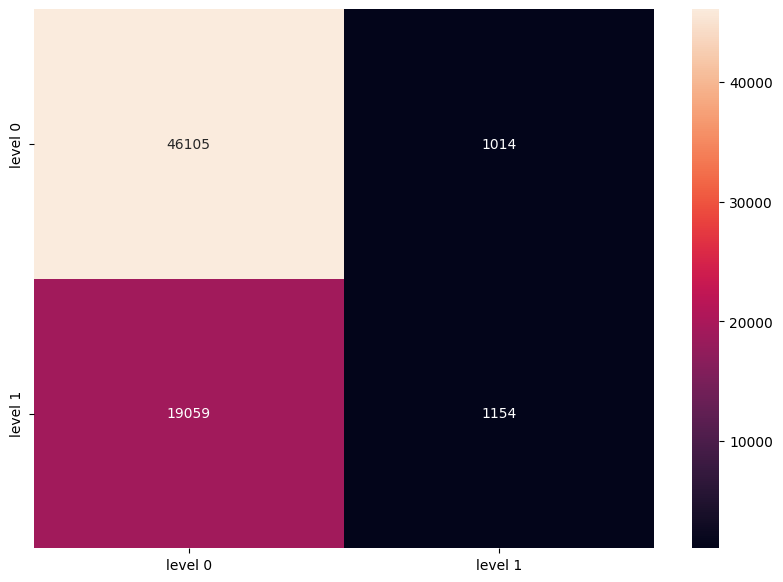

In [16]:
# cfmtrix = confusion_matrix(y_lr_test, y_pred_test)
cfmtrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_test)
df_cm = pd.DataFrame(cfmtrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt="d")